In [53]:
import pandas as pd
import numpy as np
from ensemble_boxes import nms, weighted_boxes_fusion, non_maximum_weighted
from pycocotools.coco import COCO

In [54]:
submissions = [
"/data/ephemeral/home/ensem/dino.csv",
"/data/ephemeral/home/ensem/rt.csv",
"/data/ephemeral/home/ensem/yolo11.csv",
"/data/ephemeral/home/ensem/cascade.csv",
"/data/ephemeral/home/ensem/retina.csv",
"/data/ephemeral/home/ensem/retinatta.csv",
"/data/ephemeral/home/ensem/dinotta.csv",
"/data/ephemeral/home/ensem/yolotta.csv",
"/data/ephemeral/home/ensem/yolo11final.csv",
"/data/ephemeral/home/ensem/dino_best_tta.csv",
"/data/ephemeral/home/ensem/faster.csv",
"/data/ephemeral/home/ensem/yolo8.csv",
'/data/ephemeral/home/ensem/deformable.csv'
]

In [55]:
submissions_dfs = [pd.read_csv(file) for file in submissions]

In [56]:
image_ids = submissions_dfs[0]['image_id'].tolist()

In [57]:
test_json = "/data/ephemeral/home/dataset/test.json"
coco = COCO(test_json)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [58]:
iou_thr = 0.55
method = 'wbf'
skip_box = 0.2

In [59]:
prediction_strings =[]
file_names = []

In [60]:
for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    
    # 각 submission file 별로 prediction box 좌표 불러오기
    for df in submissions_dfs:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()

        if len(predict_list) == 0 or len(predict_list) == 1:
            continue

        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []

        for box in predict_list[:, 2:6].tolist():
            image_width = image_info['width']
            image_height = image_info['height']
            box[0] = float(box[0]) / image_width
            box[1] = float(box[1]) / image_height
            box[2] = float(box[2]) / image_width
            box[3] = float(box[3]) / image_height
            box_list.append(box)

        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))

    # 예측 box가 있다면 이를 앙상블 수행
    if len(boxes_list):
        if method == 'nms':
            # NMS 사용
            boxes, scores, labels = nms(boxes_list, scores_list, labels_list, iou_thr=iou_thr)
        elif method == 'wbf':
            # WBF 사용
            boxes, scores, labels = weighted_boxes_fusion(
                boxes_list, scores_list, labels_list, 
                iou_thr=iou_thr, skip_box_thr=skip_box
            )
        elif method == 'nmw':
            # WBF 사용
            boxes, scores, labels = non_maximum_weighted(
                boxes_list, scores_list, labels_list, 
                iou_thr=iou_thr, skip_box_thr=skip_box
            )

        # 결과를 원래 이미지 크기로 변환
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += f"{int(label)} {score:.6f} {box[0] * image_info['width']:.2f} {box[1] * image_info['height']:.2f} {box[2] * image_info['width']:.2f} {box[3] * image_info['height']:.2f} "

    prediction_strings.append(prediction_string.strip())
    file_names.append(image_id)

/opt/conda/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:42: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/opt/conda/lib/python3.10/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:54: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')


In [61]:
submission = pd.DataFrame({
    'PredictionString': prediction_strings,
    'image_id': file_names
})

submission.head()

,PredictionString,image_id
0,7 0.896104 602.11 516.28 954.87 1021.47 7 0.89...,test/0000.jpg
1,5 0.720042 131.85 1.32 491.79 273.42 5 0.59210...,test/0001.jpg
2,1 0.778735 776.98 416.93 1023.79 1023.14 1 0.6...,test/0002.jpg
3,9 0.681502 146.70 259.12 912.34 822.68 9 0.304...,test/0003.jpg
4,1 0.685338 196.07 266.90 874.46 779.19 0 0.259...,test/0004.jpg


In [62]:
import cv2
import matplotlib.pyplot as plt

In [63]:
def draw_bounding_boxes(submission, index, image_folder_path):
    result = submission.iloc[index]
    
    p_string = result["PredictionString"]
    image_id = result["image_id"]
    path = f"{image_folder_path}/{image_id}"
    
    image = cv2.imread(path)
    if image is None:
        print(f"Image not found at path: {path}")
        return
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    predicted = p_string.strip().split()
    
    bboxes = []
    for i in range(0, len(predicted), 6):
        category_id = int(predicted[i])
        score = float(predicted[i + 1])
        x_min = float(predicted[i + 2])
        y_min = float(predicted[i + 3])
        x_max = float(predicted[i + 4])
        y_max = float(predicted[i + 5])
        
        bboxes.append((category_id, score, x_min, y_min, x_max, y_max))
    
    class_names = {0: 'General', 1: 'paper', 2: 'pack', 3: 'Metal', 4: 'Glass', 
                   5: 'Plastic', 6: 'Styrofoam', 7: 'Plastic bag', 8: 'Battery', 9: 'Clothing'}
    
    class_colors = {
        0: (255, 0, 0),    # Red
        1: (0, 255, 0),    # Green
        2: (0, 0, 255),    # Blue
        3: (255, 255, 0),  # Yellow
        4: (255, 0, 255),  # Magenta
        5: (0, 255, 255),  # Cyan
        6: (128, 0, 128),  # Purple
        7: (128, 128, 0),  # Olive
        8: (0, 128, 128),  # Teal
        9: (128, 128, 128) # Gray
    }

    for bbox in bboxes:
        category_id, score, x_min, y_min, x_max, y_max = bbox
        color = class_colors.get(category_id, (255, 255, 255))
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, 2)
        label = f'{class_names.get(category_id, "Unknown")}: {score:.2f}'
        cv2.putText(image, label, 
                    (int(x_min), int(y_min) - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

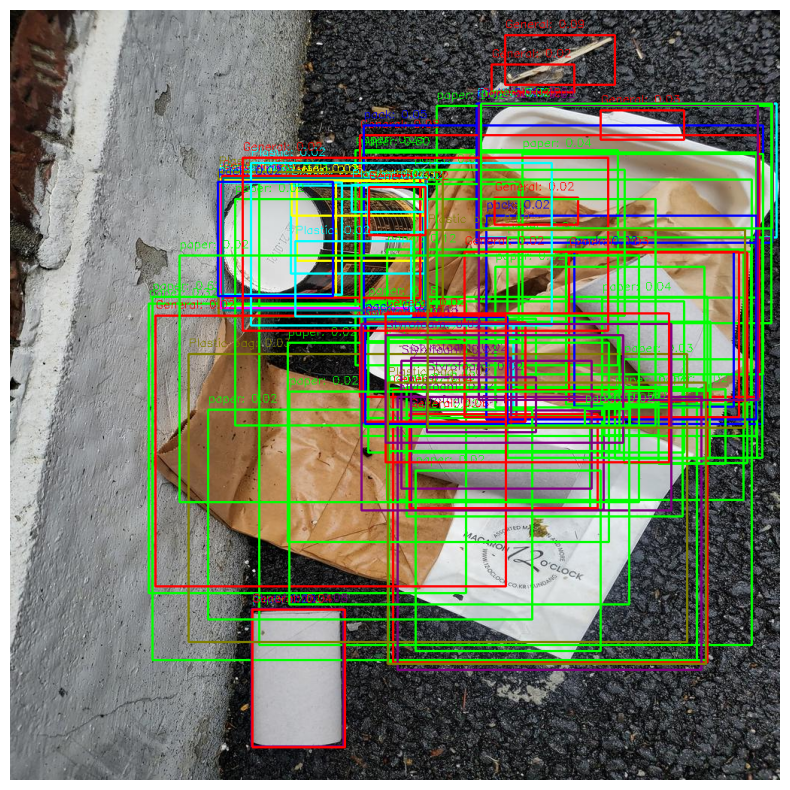

In [64]:
draw_bounding_boxes(submission, index=1498, image_folder_path="/data/ephemeral/home/dataset")

In [65]:
submission.to_csv('./13_model_wbf_0.55_0.2.csv', index=False)